# Merging Data
This notebook explores the possiblity of mergen certain data_labels into one, to improve the accuracy.
This notebook has the following outline:

## 1. Install needed packages

In [1]:
!pip install transformers datasets accelerate
!pip install librosa

## 2. Import of packages

In [169]:
import transformers
from transformers import AutoFeatureExtractor, ASTForAudioClassification, AutoModelForAudioClassification
from transformers import Trainer

from datasets import load_dataset, Dataset
from collections import Counter

import torch
import torch.nn as nn

import librosa

import random
import numpy as np
import json

from pprint import pprint

import sklearn.metrics as skm
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

## 3. Data
In this chapter we take a little look on the date and its structure. A deeper exploration was done in XXX.

### 3.1 Import Data

In [3]:
path = 'Neuronale Netze/EA - groß - Gruppenarbeit/16k_data/meta.json'
arrays = np.load('/home/jovyan/workspace/Neuronale Netze/EA - groß - Gruppenarbeit/16k_data/training_25112024.npz')
meta = json.load(open('/home/jovyan/workspace/Neuronale Netze/EA - groß - Gruppenarbeit/16k_data/meta.json', 'r'))

### 3.2 Data structure

In [4]:
print(arrays)

NpzFile '/home/jovyan/workspace/Neuronale Netze/EA - groß - Gruppenarbeit/16k_data/training_25112024.npz' with keys: X, y, groups


In [5]:
print(arrays['X'])

[[ 3.2830704e-04  9.9163875e-03  1.6845936e-02 ...  4.8440071e-03
   6.7358743e-04 -3.9298702e-03]
 [-8.2107643e-03 -9.7427005e-03 -5.7625356e-03 ...  5.6111747e-03
   7.0165722e-03  3.7530088e-03]
 [-6.0349256e-03 -1.7513758e-02 -2.4519343e-02 ...  2.4389978e-03
   1.4424410e-02  2.3104530e-02]
 ...
 [ 3.4458810e-01  3.3406031e-01  2.9483637e-01 ... -7.2613396e-03
   1.7828370e-02  5.2196458e-02]
 [ 9.2880733e-02  7.2587684e-02  9.3194686e-02 ...  9.9426378e-03
   1.3490677e-01  1.3978356e-01]
 [ 2.5695339e-02 -6.2102992e-02 -2.7688213e-02 ...  9.9716447e-03
  -9.2344247e-02 -1.7016892e-01]]


In [6]:
print(arrays['y'])

[4 4 4 4 4 4 4 4 4 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 2 2 0 4 4 4 4 0 0 0 0 0 0
 0 0 0 2 1 1 1 1 3 3 3 3 2 2 4 4 4 4 4 4 4 0 0 0 0 0 1 1 1 2 1 1 1 1 1 1 3
 3 3 3 3 3 3 3 3 3 3 1 1 1 4 4 4 4 4 4 4 2 4 4 4 4 4 1 1 1 1 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 2 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 1 1 1 1 3
 3 3 1 3 3 3 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3
 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0
 0 0 0 1 1 3 3 3 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 1 1 1 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 

In [7]:
print(arrays['groups'])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3

In [8]:
pprint(meta)

{'labelfile': 'project-6-at-2024-11-23-15-47-9e286610.json',
 'labels': {'Boring': 4,
            'Celebration': 3,
            'Chanting/Singing': 0,
            'Disappointment': 2,
            'Excitement': 1},
 'sample_rate': 16000,
 'snippet_sec': 1,
 'sources': ['HKvsBHUTAN001.wav',
             'HKvsBHUTAN002.wav',
             'HKvsBRUNEI.wav',
             '2023716VS.wav',
             '1ExcitementDisappointment.MP3.wav',
             '2ExcitementCelebration.MP3.wav',
             '3Boring.MP3.wav',
             'Boring_001.wav',
             'Celebration_001.MP3.wav',
             'Celebration_002.MP3.wav',
             'Combine.MP3.wav',
             'Disappointment_001.wav',
             'Disappointment_002.wav',
             'Excitement_001.MP3.wav',
             'HongKongvsSingaporeInternationalFriendlyMongkokStadium.wav',
             'test.MP3.wav']}


## 4. Base-Line-Model
The Base-Line-Model is our resulting model of the notebook XX.

In [9]:
model_name = "MIT/ast-finetuned-audioset-10-10-0.4593"
device = 'cuda'

### 4.1 Prepare Data for Base-Line-Model

In [10]:
arrays

NpzFile '/home/jovyan/workspace/Neuronale Netze/EA - groß - Gruppenarbeit/16k_data/training_25112024.npz' with keys: X, y, groups

In [11]:
meta['labels']

{'Chanting/Singing': 0,
 'Excitement': 1,
 'Disappointment': 2,
 'Celebration': 3,
 'Boring': 4}

Prepare the data for the train and test. First we format the data.

In [12]:
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)

preprocessed_audio = feature_extractor(
    arrays['X'],
    sampling_rate = meta['sample_rate'],
    return_tensors = "pt"
)

hf_dataset = Dataset.from_dict({
    "input_values": preprocessed_audio['input_values'],
    "label": arrays['y'],
})

In [13]:
hf_dataset

Dataset({
    features: ['input_values', 'label'],
    num_rows: 906
})

The Second Step is the data-splitting into train and test data.

In [14]:
gss = GroupShuffleSplit(n_splits=10, train_size=.8, random_state=42)
gss.get_n_splits()

for i, (train_index, test_index) in enumerate(gss.split(**arrays)):
    print(f"Fold {i}:")
    print(f"  Train: source={set(arrays['groups'][train_index])}")
    print(f"  Test:  source={set(arrays['groups'][test_index])}")

Fold 0:
  Train: source={np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(15)}
  Test:  source={np.int64(0), np.int64(1), np.int64(5), np.int64(14)}
Fold 1:
  Train: source={np.int64(0), np.int64(1), np.int64(3), np.int64(4), np.int64(5), np.int64(7), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(14), np.int64(15)}
  Test:  source={np.int64(8), np.int64(2), np.int64(13), np.int64(6)}
Fold 2:
  Train: source={np.int64(0), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(14), np.int64(15)}
  Test:  source={np.int64(8), np.int64(1), np.int64(13), np.int64(5)}
Fold 3:
  Train: source={np.int64(1), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(15)}
  Test:  source={np.int64(0), np.int64(2), np.

In [15]:
(train_index, test_index) = next(gss.split(**arrays))

In [16]:
train_ds = hf_dataset.select(train_index)
train_ds

Dataset({
    features: ['input_values', 'label'],
    num_rows: 677
})

In [17]:
test_ds = hf_dataset.select(test_index)
test_ds

Dataset({
    features: ['input_values', 'label'],
    num_rows: 229
})

### 4.2 Define model and its arguments

In [18]:
model2train = AutoModelForAudioClassification.from_pretrained(
    model_name,
    num_labels = len(meta['labels']),
    label2id = meta['labels'],
    id2label = {v:k for k,v in meta['labels'].items()},
    ignore_mismatched_sizes = True
)

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
batch_size = 8
args = transformers.TrainingArguments(
    f'{model_name.split("/")[-1]}-ft_stadium',

    learning_rate=1e-5,
    warmup_ratio=0.1,


    eval_strategy = "steps",
    eval_steps = 10,
    logging_steps=10,

    save_strategy = "epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,

    gradient_accumulation_steps=4,
    num_train_epochs=5,
    load_best_model_at_end=False,
    push_to_hub=False,
)

In [20]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels").to(torch.long)  # Labels in int64 konvertieren
        outputs = model(**inputs)
        logits = outputs.logits.to(torch.float32)  # Logits in float32 konvertieren

        # Loss-function with class weights
        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss

    def compute_metrics(pred):
        labels = pred.label_ids
        preds = pred.predictions.argmax(-1)
        
        metrics = {
            'accuracy': skm.accuracy_score(labels, preds),
            'macro_f1': skm.f1_score(labels, preds, average='macro'),
            'weighted_f1': skm.f1_score(labels, preds, average='weighted')
        }
        
        return metrics

In [21]:
class_weights = compute_class_weight(
    class_weight="balanced",  
    classes=np.unique(hf_dataset['label']),  
    y = hf_dataset['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print("Class Weights:", class_weights)

Class Weights: tensor([0.4897, 1.8875, 3.0200, 2.1318, 0.6142], device='cuda:0')


In [22]:
trainer = CustomTrainer(
    model=model2train,
    args=args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    processing_class = feature_extractor, #tokenizer=feature_extractor,
    class_weights=class_weights,
    compute_metrics=CustomTrainer.compute_metrics
)

### 4.3 Train Base-Line-Model

In [23]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
10,1.684600,1.477028,0.441048,0.312360,0.457456
20,1.241400,1.050055,0.733624,0.657671,0.748780
30,0.690300,0.787301,0.790393,0.670128,0.794165
40,0.515900,0.717811,0.772926,0.662416,0.790746
50,0.362300,0.636677,0.807860,0.659130,0.802443
60,0.333200,0.619444,0.816594,0.692930,0.819413
70,0.281500,0.610140,0.812227,0.704595,0.821796
80,0.206800,0.590386,0.816594,0.663572,0.803889
90,0.178200,0.603741,0.803493,0.660093,0.801881
100,0.160200,0.588373,0.807860,0.670452,0.805710


TrainOutput(global_step=105, training_loss=0.5461433677446275, metrics={'train_runtime': 444.4349, 'train_samples_per_second': 7.616, 'train_steps_per_second': 0.236, 'total_flos': 2.2043569543446528e+17, 'train_loss': 0.5461433677446275, 'epoch': 4.8})

In [24]:
training_logs  = trainer.state.log_history
len(training_logs)

21

In [25]:
training_logs

[{'loss': 1.6846,
  'grad_norm': 12.245880126953125,
  'learning_rate': 9.090909090909091e-06,
  'epoch': 0.47058823529411764,
  'step': 10},
 {'eval_loss': 1.4770281314849854,
  'eval_accuracy': 0.4410480349344978,
  'eval_macro_f1': 0.31235988635167844,
  'eval_weighted_f1': 0.457455647576855,
  'eval_runtime': 14.6022,
  'eval_samples_per_second': 15.683,
  'eval_steps_per_second': 1.986,
  'epoch': 0.47058823529411764,
  'step': 10},
 {'loss': 1.2414,
  'grad_norm': 9.912283897399902,
  'learning_rate': 9.042553191489362e-06,
  'epoch': 0.9411764705882353,
  'step': 20},
 {'eval_loss': 1.0500545501708984,
  'eval_accuracy': 0.7336244541484717,
  'eval_macro_f1': 0.6576714096890959,
  'eval_weighted_f1': 0.7487802264684431,
  'eval_runtime': 14.6002,
  'eval_samples_per_second': 15.685,
  'eval_steps_per_second': 1.986,
  'epoch': 0.9411764705882353,
  'step': 20},
 {'loss': 0.6903,
  'grad_norm': 11.561127662658691,
  'learning_rate': 7.97872340425532e-06,
  'epoch': 1.376470588235

In [26]:
loss_values = [log["loss"] for log in training_logs if "loss" in log]
loss_values = [log["loss"] for log in training_logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in training_logs if "eval_loss" in log]
steps = [log["step"] for log in training_logs if "loss" in log]

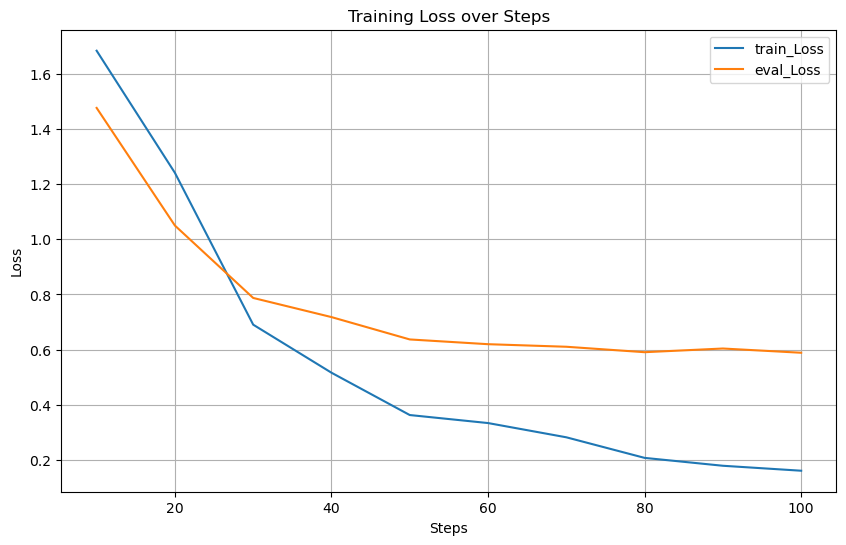

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(steps, loss_values, label="train_Loss")
plt.plot(steps, eval_loss, label="eval_Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.legend()
plt.grid()
plt.show()

### 4.4 Results on test-data

In [28]:
pred = trainer.predict(test_ds)

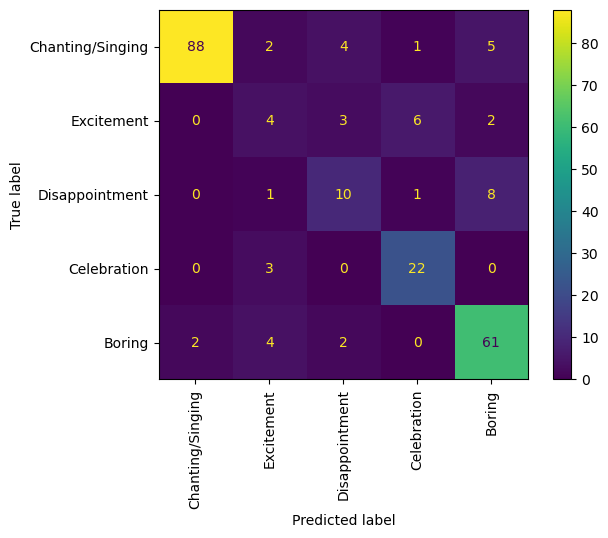

In [29]:
cmd = skm.ConfusionMatrixDisplay(
    skm.confusion_matrix(pred.label_ids, pred.predictions.argmax(1)),
    display_labels = meta.get('labels').keys()
)
cmd.plot(xticks_rotation="vertical")

In [30]:
print(classification_report(pred.label_ids, pred.predictions.argmax(1)))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93       100
           1       0.29      0.27      0.28        15
           2       0.53      0.50      0.51        20
           3       0.73      0.88      0.80        25
           4       0.80      0.88      0.84        69

    accuracy                           0.81       229
   macro avg       0.67      0.68      0.67       229
weighted avg       0.81      0.81      0.81       229



In [31]:
id2label = {v:k for k,v in meta['labels'].items()}

In [32]:
print(classification_report(pred.label_ids, pred.predictions.argmax(1)))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93       100
           1       0.29      0.27      0.28        15
           2       0.53      0.50      0.51        20
           3       0.73      0.88      0.80        25
           4       0.80      0.88      0.84        69

    accuracy                           0.81       229
   macro avg       0.67      0.68      0.67       229
weighted avg       0.81      0.81      0.81       229



In [33]:
cm = confusion_matrix(pred.label_ids, pred.predictions.argmax(1), normalize='true')

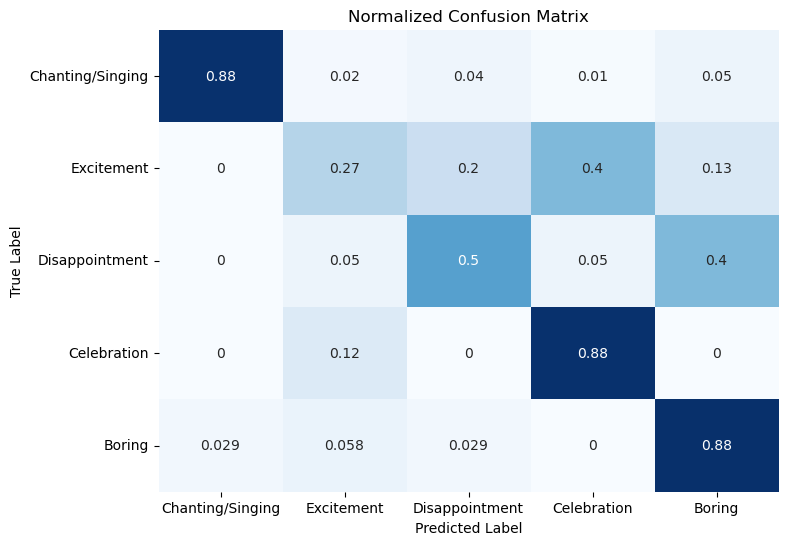

In [34]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", cbar=False, xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()

## 5. Combine Labels: Celebration und Excitement

In [76]:
model_name = "MIT/ast-finetuned-audioset-10-10-0.4593"
device = 'cuda'

### 5.1 Prepare Data

In [77]:
arrays['y']

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0,
       0, 0, 2, 2, 0, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1,
       1, 3, 3, 3, 3, 2, 2, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 4,
       4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 0, 0, 0, 0, 0, 0, 0, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#### 5.1.1 Combine Labels Celebration und Excitement

In [78]:
nparray2 = np.where(arrays['y']==3, 1, arrays['y'])
nparray2 = np.where(nparray2==4, 3, nparray2)
nparray2

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 2, 2, 0, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3,
       3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 0, 0, 0, 0, 0, 0, 0, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [79]:
meta_labels = {
     'Chanting/Singing': 0,
     'Excitement/Celebration': 1,
     'Disappointment': 2,
     'Boring': 3
}
meta_labels

{'Chanting/Singing': 0,
 'Excitement/Celebration': 1,
 'Disappointment': 2,
 'Boring': 3}

#### 5.1.2 Preprocessing

In [80]:
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)

preprocessed_audio = feature_extractor(
    arrays['X'],
    sampling_rate = meta['sample_rate'],
    return_tensors = "pt"
)

hf_dataset = Dataset.from_dict({
    "input_values": preprocessed_audio['input_values'],
    "label": nparray2,
})

In [81]:
hf_dataset

Dataset({
    features: ['input_values', 'label'],
    num_rows: 906
})

#### 5.1.3 Train- und test-split

In [82]:
gss = GroupShuffleSplit(n_splits=10, train_size=.8, random_state=42)
gss.get_n_splits()

for i, (train_index, test_index) in enumerate(gss.split(**arrays)):
    print(f"Fold {i}:")
    print(f"  Train: source={set(arrays['groups'][train_index])}")
    print(f"  Test:  source={set(arrays['groups'][test_index])}")

Fold 0:
  Train: source={np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(15)}
  Test:  source={np.int64(0), np.int64(1), np.int64(5), np.int64(14)}
Fold 1:
  Train: source={np.int64(0), np.int64(1), np.int64(3), np.int64(4), np.int64(5), np.int64(7), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(14), np.int64(15)}
  Test:  source={np.int64(8), np.int64(2), np.int64(13), np.int64(6)}
Fold 2:
  Train: source={np.int64(0), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(14), np.int64(15)}
  Test:  source={np.int64(8), np.int64(1), np.int64(13), np.int64(5)}
Fold 3:
  Train: source={np.int64(1), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(15)}
  Test:  source={np.int64(0), np.int64(2), np.

In [83]:
(train_index, test_index) = next(gss.split(**arrays))

In [92]:
train_ds = hf_dataset.select(train_index)
train_ds

Dataset({
    features: ['input_values', 'label'],
    num_rows: 677
})

In [93]:
test_ds = hf_dataset.select(test_index)
test_ds

Dataset({
    features: ['input_values', 'label'],
    num_rows: 229
})

### 5.2 Define model and its arguments

In [94]:
model2train = AutoModelForAudioClassification.from_pretrained(
    model_name,
    num_labels = len(meta_labels),
    label2id = meta_labels,
    id2label = {v:k for k,v in meta_labels.items()},
    ignore_mismatched_sizes = True
)

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [95]:
batch_size = 8
args = transformers.TrainingArguments(
    f'{model_name.split("/")[-1]}-ft_stadium',

    learning_rate=1e-5,
    warmup_ratio=0.1,

    eval_strategy = "steps",
    eval_steps = 10,
    logging_steps=10,

    save_strategy = "epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,

    gradient_accumulation_steps=4,
    num_train_epochs=5,
    load_best_model_at_end=False,
    push_to_hub=False,
)

In [96]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels").to(torch.long)  # Labels in int64 konvertieren
        outputs = model(**inputs)
        logits = outputs.logits.to(torch.float32)  # Logits in float32 konvertieren

        # Loss-function with class weights
        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss

    def compute_metrics(pred):
        labels = pred.label_ids
        preds = pred.predictions.argmax(-1)
        
        metrics = {
            'accuracy': skm.accuracy_score(labels, preds),
            'macro_f1': skm.f1_score(labels, preds, average='macro'),
            'weighted_f1': skm.f1_score(labels, preds, average='weighted')
        }
        
        return metrics

In [97]:
class_weights = compute_class_weight(
    class_weight="balanced",  
    classes=np.unique( hf_dataset['label']),  
    y = hf_dataset['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print("Class Weights:", class_weights)

Class Weights: tensor([0.6122, 1.2514, 3.7750, 0.7678], device='cuda:0')


In [98]:
trainer = CustomTrainer(
    model=model2train,
    args=args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    processing_class = feature_extractor, #tokenizer=feature_extractor,
    class_weights=class_weights,
    compute_metrics=CustomTrainer.compute_metrics
)

### 5.3 Train model

In [99]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
10,1.466100,1.300210,0.427948,0.288414,0.396168
20,1.050200,0.932918,0.655022,0.610460,0.655565
30,0.497700,0.701421,0.799127,0.694899,0.783973
40,0.374700,0.613318,0.807860,0.761411,0.814469
50,0.204400,0.561840,0.842795,0.788974,0.838458
60,0.219500,0.504076,0.825328,0.769686,0.827099
70,0.235200,0.488751,0.829694,0.777492,0.830247
80,0.125700,0.496404,0.860262,0.797146,0.854705
90,0.109200,0.504642,0.842795,0.801542,0.840407
100,0.114300,0.472276,0.855895,0.812778,0.853359


TrainOutput(global_step=105, training_loss=0.4223666517507462, metrics={'train_runtime': 451.3047, 'train_samples_per_second': 7.5, 'train_steps_per_second': 0.233, 'total_flos': 2.2043372873475686e+17, 'train_loss': 0.4223666517507462, 'epoch': 4.8})

In [100]:
training_logs  = trainer.state.log_history
training_logs

[{'loss': 1.4661,
  'grad_norm': 10.76355266571045,
  'learning_rate': 9.090909090909091e-06,
  'epoch': 0.47058823529411764,
  'step': 10},
 {'eval_loss': 1.3002099990844727,
  'eval_accuracy': 0.4279475982532751,
  'eval_macro_f1': 0.28841422804561456,
  'eval_weighted_f1': 0.39616833045300875,
  'eval_runtime': 14.3638,
  'eval_samples_per_second': 15.943,
  'eval_steps_per_second': 2.019,
  'epoch': 0.47058823529411764,
  'step': 10},
 {'loss': 1.0502,
  'grad_norm': 9.615665435791016,
  'learning_rate': 9.042553191489362e-06,
  'epoch': 0.9411764705882353,
  'step': 20},
 {'eval_loss': 0.9329177141189575,
  'eval_accuracy': 0.6550218340611353,
  'eval_macro_f1': 0.6104604900130062,
  'eval_weighted_f1': 0.6555646868502293,
  'eval_runtime': 14.6616,
  'eval_samples_per_second': 15.619,
  'eval_steps_per_second': 1.978,
  'epoch': 0.9411764705882353,
  'step': 20},
 {'loss': 0.4977,
  'grad_norm': 14.356802940368652,
  'learning_rate': 7.97872340425532e-06,
  'epoch': 1.37647058823

In [101]:
loss_values = [log["loss"] for log in training_logs if "loss" in log]
loss_values = [log["loss"] for log in training_logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in training_logs if "eval_loss" in log]
steps = [log["step"] for log in training_logs if "loss" in log]

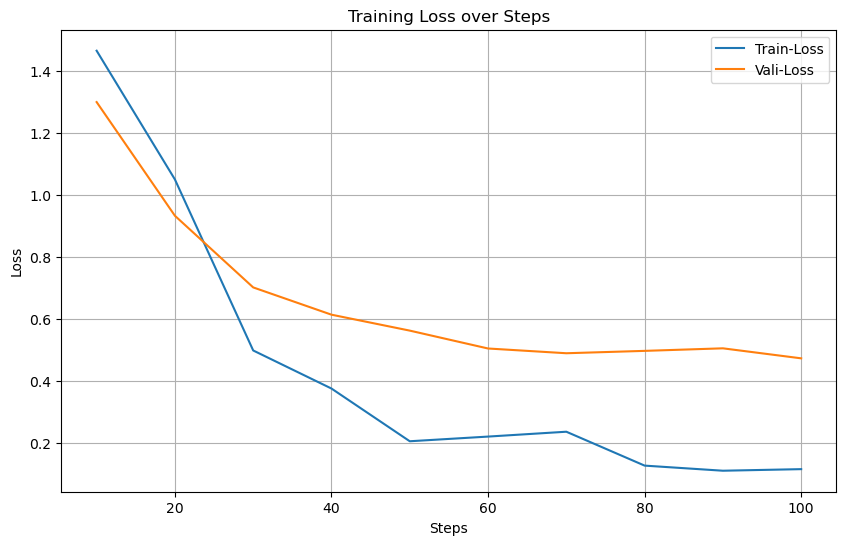

In [103]:
plt.figure(figsize=(10, 6))
plt.plot(steps, loss_values, label="Train-Loss")
plt.plot(steps, eval_loss, label="Vali-Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.legend()
plt.grid()
plt.show()

### 5.4 Results on test data

In [104]:
pred = trainer.predict(test_ds)

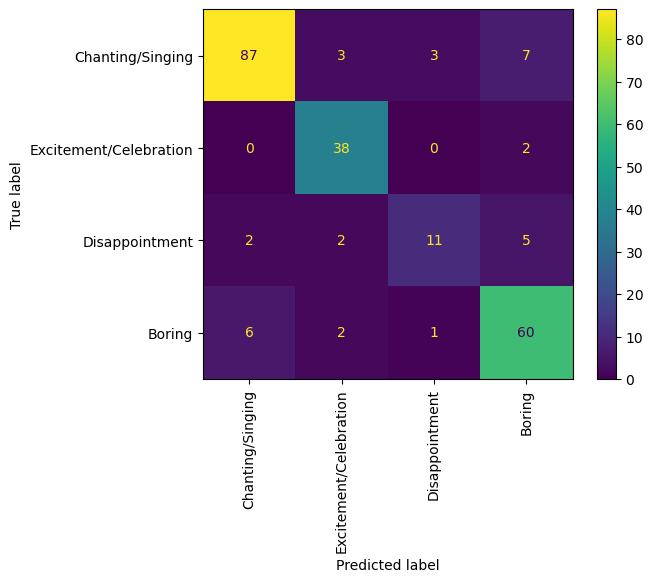

In [105]:
cmd = skm.ConfusionMatrixDisplay(
    skm.confusion_matrix(pred.label_ids, pred.predictions.argmax(1)),
    display_labels = meta_labels.keys()
)
cmd.plot(xticks_rotation="vertical")

In [106]:
print(classification_report(pred.label_ids, pred.predictions.argmax(1)))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89       100
           1       0.84      0.95      0.89        40
           2       0.73      0.55      0.63        20
           3       0.81      0.87      0.84        69

    accuracy                           0.86       229
   macro avg       0.83      0.81      0.81       229
weighted avg       0.86      0.86      0.85       229



In [107]:
id2label = {v:k for k,v in meta_labels.items()}

In [108]:
print(classification_report(pred.label_ids, pred.predictions.argmax(1)))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89       100
           1       0.84      0.95      0.89        40
           2       0.73      0.55      0.63        20
           3       0.81      0.87      0.84        69

    accuracy                           0.86       229
   macro avg       0.83      0.81      0.81       229
weighted avg       0.86      0.86      0.85       229



In [109]:
cm = confusion_matrix(pred.label_ids, pred.predictions.argmax(1), normalize='true')

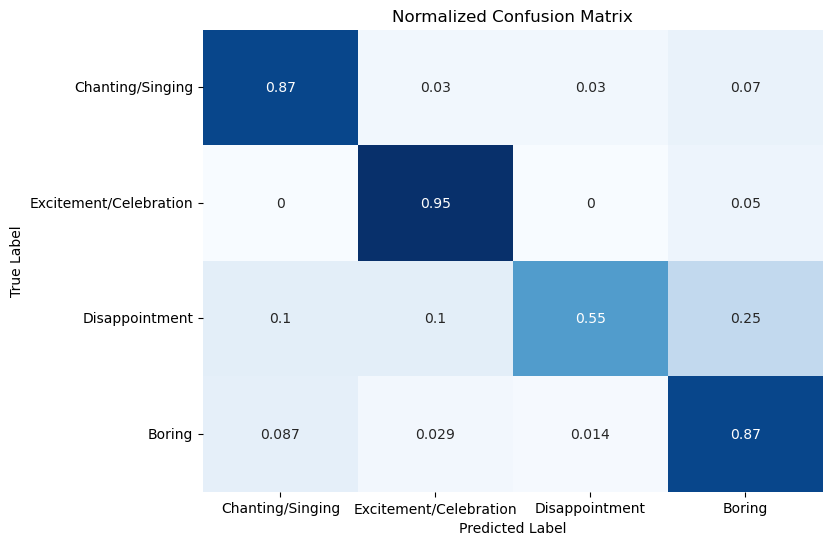

In [110]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", cbar=False, xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()

## 6. Combine Labels: Celebration & Excitement and Disappointment & Boring

In [127]:
model_name = "MIT/ast-finetuned-audioset-10-10-0.4593"
device = 'cuda'

### 6.1 Prepare Data

#### 6.1.1 Combine labels: Celebration & Excitement and Disappointment & Boring

In [128]:
nparray2 = np.where(arrays['y']==3, 1, arrays['y'])
nparray2 = np.where(nparray2==4, 2, nparray2)
nparray2

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [129]:
meta_labels = {
     'Chanting/Singing': 0,
     'Excitement': 1,
     'Disappointment/Boring': 2,
}
meta_labels

{'Chanting/Singing': 0, 'Excitement': 1, 'Disappointment/Boring': 2}

#### 6.1.2 Preprocessing

In [130]:
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)

preprocessed_audio = feature_extractor(
    arrays['X'],
    sampling_rate = meta['sample_rate'],
    return_tensors = "pt"
)

hf_dataset = Dataset.from_dict({
    "input_values": preprocessed_audio['input_values'],
    "label": nparray2,
})

In [131]:
hf_dataset

Dataset({
    features: ['input_values', 'label'],
    num_rows: 906
})

In [132]:
hf_dataset['label']

[2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


#### 6.1.3 Train- und test-split

In [133]:
gss = GroupShuffleSplit(n_splits=10, train_size=.8, random_state=42)
gss.get_n_splits()

for i, (train_index, test_index) in enumerate(gss.split(**arrays)):
    print(f"Fold {i}:")
    print(f"  Train: source={set(arrays['groups'][train_index])}")
    print(f"  Test:  source={set(arrays['groups'][test_index])}")

Fold 0:
  Train: source={np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(15)}
  Test:  source={np.int64(0), np.int64(1), np.int64(5), np.int64(14)}
Fold 1:
  Train: source={np.int64(0), np.int64(1), np.int64(3), np.int64(4), np.int64(5), np.int64(7), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(14), np.int64(15)}
  Test:  source={np.int64(8), np.int64(2), np.int64(13), np.int64(6)}
Fold 2:
  Train: source={np.int64(0), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(14), np.int64(15)}
  Test:  source={np.int64(8), np.int64(1), np.int64(13), np.int64(5)}
Fold 3:
  Train: source={np.int64(1), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(15)}
  Test:  source={np.int64(0), np.int64(2), np.

In [134]:
(train_index, test_index) = next(gss.split(**arrays))

In [135]:
train_ds = hf_dataset.select(train_index)
train_ds

Dataset({
    features: ['input_values', 'label'],
    num_rows: 677
})

In [136]:
test_ds = hf_dataset.select(test_index)
test_ds

Dataset({
    features: ['input_values', 'label'],
    num_rows: 229
})

### 6.2 Define model and its arguments

In [137]:
model2train = AutoModelForAudioClassification.from_pretrained(
    model_name,
    num_labels = len(meta_labels),
    label2id = meta_labels,
    id2label = {v:k for k,v in meta_labels.items()},
    ignore_mismatched_sizes = True
)

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [138]:
batch_size = 8
args = transformers.TrainingArguments(
    f'{model_name.split("/")[-1]}-ft_stadium',

    learning_rate=1e-5,
    warmup_ratio=0.1,


    eval_strategy = "steps",
    eval_steps = 10,
    logging_steps=10,

    save_strategy = "epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,

    gradient_accumulation_steps=4,
    num_train_epochs=5,
    load_best_model_at_end=False,
    push_to_hub=False,
)

In [139]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels").to(torch.long)  # Labels in int64 konvertieren
        outputs = model(**inputs)
        logits = outputs.logits.to(torch.float32)  # Logits in float32 konvertieren

        # Loss-function with class weights
        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss

    def compute_metrics(pred):
        labels = pred.label_ids
        preds = pred.predictions.argmax(-1)
        
        metrics = {
            'accuracy': skm.accuracy_score(labels, preds),
            'macro_f1': skm.f1_score(labels, preds, average='macro'),
            'weighted_f1': skm.f1_score(labels, preds, average='weighted')
        }
        
        return metrics

In [140]:
class_weights = compute_class_weight(
    class_weight="balanced",  
    classes=np.unique( hf_dataset['label']),  
    y = hf_dataset['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print("Class Weights:", class_weights)

Class Weights: tensor([0.8162, 1.6685, 0.8507], device='cuda:0')


In [141]:
trainer = CustomTrainer(
    model=model2train,
    args=args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    processing_class = feature_extractor, #tokenizer=feature_extractor,
    class_weights=class_weights,
    compute_metrics=CustomTrainer.compute_metrics
)

### 6.3 Train model

In [142]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
10,1.169800,0.796186,0.703057,0.551250,0.650358
20,0.654700,0.561745,0.755459,0.735612,0.773601
30,0.314400,0.326809,0.895197,0.879857,0.899377
40,0.267300,0.294830,0.917031,0.909319,0.917987
50,0.190900,0.247135,0.921397,0.919729,0.921899
60,0.155100,0.264643,0.903930,0.892299,0.906121
70,0.131300,0.264777,0.899563,0.885608,0.902504
80,0.102300,0.231381,0.921397,0.921727,0.922165
90,0.069100,0.232567,0.925764,0.918033,0.926575
100,0.075400,0.246378,0.917031,0.909241,0.917965


TrainOutput(global_step=105, training_loss=0.3001908317917869, metrics={'train_runtime': 452.0136, 'train_samples_per_second': 7.489, 'train_steps_per_second': 0.232, 'total_flos': 2.2043176203504845e+17, 'train_loss': 0.3001908317917869, 'epoch': 4.8})

In [143]:
training_logs  = trainer.state.log_history
training_logs

[{'loss': 1.1698,
  'grad_norm': 11.293336868286133,
  'learning_rate': 9.090909090909091e-06,
  'epoch': 0.47058823529411764,
  'step': 10},
 {'eval_loss': 0.7961860299110413,
  'eval_accuracy': 0.7030567685589519,
  'eval_macro_f1': 0.5512501664166222,
  'eval_weighted_f1': 0.6503578645614457,
  'eval_runtime': 14.949,
  'eval_samples_per_second': 15.319,
  'eval_steps_per_second': 1.94,
  'epoch': 0.47058823529411764,
  'step': 10},
 {'loss': 0.6547,
  'grad_norm': 8.857486724853516,
  'learning_rate': 9.042553191489362e-06,
  'epoch': 0.9411764705882353,
  'step': 20},
 {'eval_loss': 0.5617448687553406,
  'eval_accuracy': 0.7554585152838428,
  'eval_macro_f1': 0.7356119204904475,
  'eval_weighted_f1': 0.7736010979374058,
  'eval_runtime': 14.5669,
  'eval_samples_per_second': 15.721,
  'eval_steps_per_second': 1.991,
  'epoch': 0.9411764705882353,
  'step': 20},
 {'loss': 0.3144,
  'grad_norm': 4.308926105499268,
  'learning_rate': 7.97872340425532e-06,
  'epoch': 1.376470588235294

In [144]:
loss_values = [log["loss"] for log in training_logs if "loss" in log]
loss_values = [log["loss"] for log in training_logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in training_logs if "eval_loss" in log]
steps = [log["step"] for log in training_logs if "loss" in log]

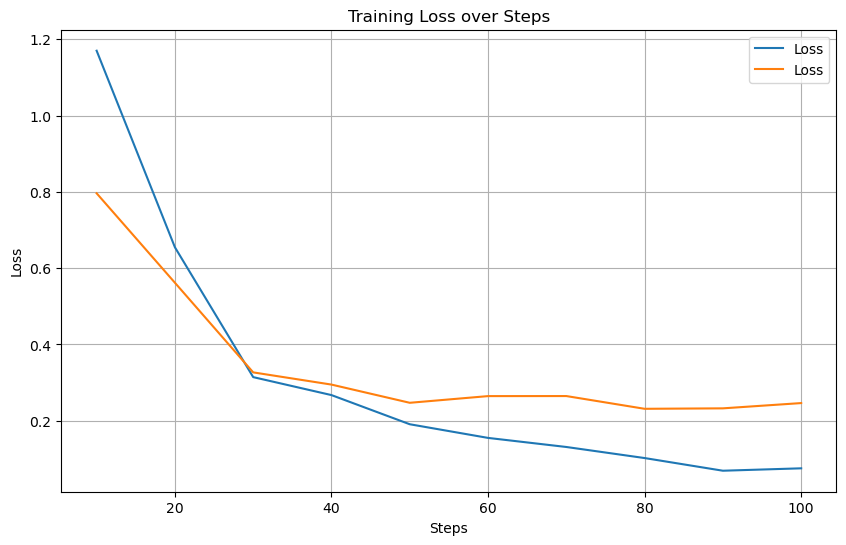

In [145]:
plt.figure(figsize=(10, 6))
plt.plot(steps, loss_values, label="Train-Loss")
plt.plot(steps, eval_loss, label="Vali-Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.legend()
plt.grid()
plt.show()

### 6.4 Results on test data

In [146]:
pred = trainer.predict(test_ds)

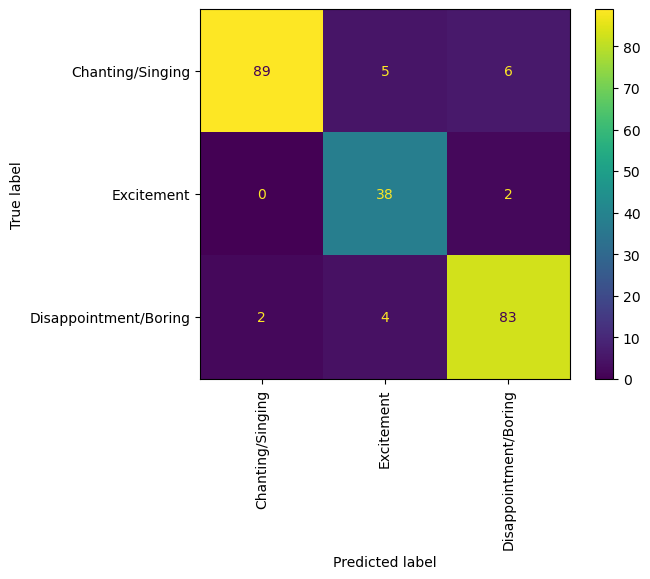

In [147]:
cmd = skm.ConfusionMatrixDisplay(
    skm.confusion_matrix(pred.label_ids, pred.predictions.argmax(1)),
    display_labels = meta_labels.keys()
)
cmd.plot(xticks_rotation="vertical")

In [148]:
print(skm.classification_report(pred.label_ids, pred.predictions.argmax(1)))

              precision    recall  f1-score   support

           0       0.98      0.89      0.93       100
           1       0.81      0.95      0.87        40
           2       0.91      0.93      0.92        89

    accuracy                           0.92       229
   macro avg       0.90      0.92      0.91       229
weighted avg       0.92      0.92      0.92       229



In [149]:
id2label = {v:k for k,v in meta_labels.items()}

In [150]:
print(classification_report(pred.label_ids, pred.predictions.argmax(1)))

              precision    recall  f1-score   support

           0       0.98      0.89      0.93       100
           1       0.81      0.95      0.87        40
           2       0.91      0.93      0.92        89

    accuracy                           0.92       229
   macro avg       0.90      0.92      0.91       229
weighted avg       0.92      0.92      0.92       229



In [151]:
cm = confusion_matrix(pred.label_ids, pred.predictions.argmax(1), normalize='true')

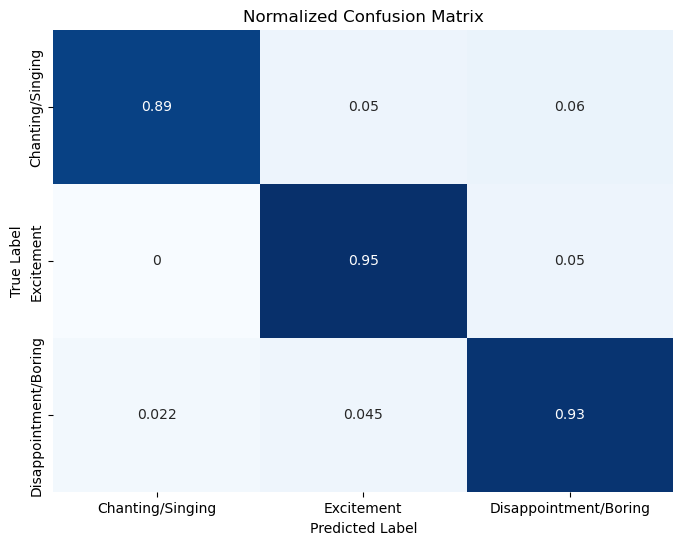

In [152]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", cbar=False, xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()

## 7. Conclusion of reducing labels

## 8. Model: combining celebration & excitement with data Augmentation

In [153]:
model_name = "MIT/ast-finetuned-audioset-10-10-0.4593"
device = 'cuda'

### 8.1 Prepare data for model

In [154]:
arrays['y']

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0,
       0, 0, 2, 2, 0, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1,
       1, 3, 3, 3, 3, 2, 2, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 4,
       4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 0, 0, 0, 0, 0, 0, 0, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#### 8.1.1 Combining labels

In [155]:
nparray2 = np.where(arrays['y']==3, 1, arrays['y'])
nparray2 = np.where(nparray2==4, 3, nparray2)
nparray2

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 2, 2, 0, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3,
       3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 0, 0, 0, 0, 0, 0, 0, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [156]:
meta_labels = {
     'Chanting/Singing': 0,
     'Excitement/Celebration': 1,
     'Disappointment': 2,
     'Boring': 3
}
meta_labels

{'Chanting/Singing': 0,
 'Excitement/Celebration': 1,
 'Disappointment': 2,
 'Boring': 3}

<Axes: >

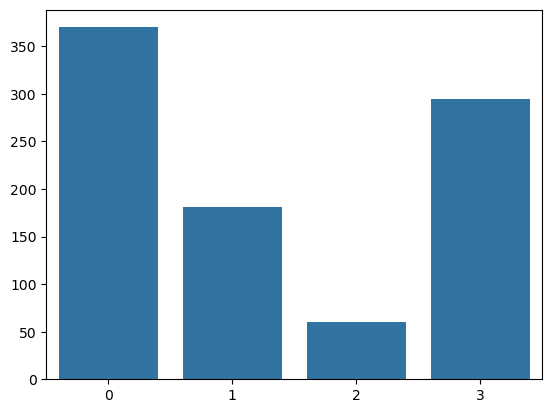

In [173]:
sns.barplot(Counter(nparray2)) #ToDo: Nücchtener und Beschriftung

#### 8.1.2 Augmentation

In [157]:
def add_noise(audio, noise_factor=0.005):
    noise = np.random.randn(len(audio)) * noise_factor
    augmented_audio = audio + noise
    return np.clip(augmented_audio, -1.0, 1.0)  # Clips the audio between -1 and 1

def pitch_shift(audio, sr, shift=2):
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=shift)

def time_stretch(audio, rate=1.1):
    return librosa.effects.time_stretch(audio, rate=rate)

# Beispiel eines Augmentierungsprozesses
def augment_audio(audio, sr):
    augmentation_type = random.choice(['noise', 'pitch', 'stretch'])
    
    if augmentation_type == 'noise':
        return add_noise(audio)
    elif augmentation_type == 'pitch':
        return pitch_shift(audio, sr)
    elif augmentation_type == 'stretch':
        return time_stretch(audio)
    
    return audio

In [158]:
def process_and_augment_dataset(arrays_X, arrays_y, arrays_groups, meta, feature_extractor, labels_to_augment, n_augments=5):
    augmented_audio_data = []
    augmented_labels = []
    
    sr = meta['sample_rate']
    
    for i, audio in enumerate(arrays_X):
        label = arrays_y[i]
        
        # Originale Daten hinzufügen
        preprocessed_audio = feature_extractor(
            audio,
            sampling_rate=sr,
            return_tensors="pt"
        )
        augmented_audio_data.append(preprocessed_audio['input_values'])
        augmented_labels.append(label)  # Originales Label
        
        # Augmentierung nur für Labels 1 und 2
        if label in labels_to_augment:
            for _ in range(n_augments):
                # Augmentierung auf rohen Audiodaten anwenden
                augmented_audio = augment_audio(audio, sr)
                
                # Feature-Extraktion nach der Augmentierung
                preprocessed_audio = feature_extractor(
                    augmented_audio,
                    sampling_rate=sr,
                    return_tensors="pt"
                )
                
                augmented_audio_data.append(preprocessed_audio['input_values'])
                augmented_labels.append(label)  # Augmentiertes Label
    
    # Alle augmentierten Eingabewerte kombinieren
    input_values = torch.cat(augmented_audio_data, dim=0)
    
    hf_dataset = Dataset.from_dict({
        "input_values": input_values.numpy(),  # In NumPy-Array umwandeln
        "label": np.array(augmented_labels)  # Labels als NumPy-Array
    })

    return hf_dataset

In [ ]:
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)

hf_dataset = process_and_augment_dataset(
    arrays_X= arrays['X'],
    arrays_y= nparray2,
    arrays_groups= arrays['groups'],
    meta= meta, 
    feature_extractor= feature_extractor,
    labels_to_augment=[1],
    n_augments=2 # bei <1 entstehen eventuell duplikate
) 

In [ ]:
hf_dataset

In [ ]:
Counter(hf_dataset['label'])

In [ ]:
sns.barplot(Counter(hf_dataset['label']))

#### 8.1.3 Train- and test-split

In [ ]:
gss = GroupShuffleSplit(n_splits=10, train_size=.8, random_state=42)
gss.get_n_splits()

for i, (train_index, test_index) in enumerate(gss.split(**arrays)):
    print(f"Fold {i}:")
    print(f"  Train: source={set(arrays['groups'][train_index])}")
    print(f"  Test:  source={set(arrays['groups'][test_index])}")

In [ ]:
# select one train test split
(train_index, test_index) = next(gss.split(**arrays))

In [ ]:
train_ds = hf_dataset.select(train_index)
train_ds

In [ ]:
test_ds = hf_dataset.select(test_index)
test_ds

### 8.2 Define model and its arguments

In [ ]:
model2train = AutoModelForAudioClassification.from_pretrained(
    model_name,
    num_labels = len(meta['labels']),
    label2id = meta['labels'],
    id2label = {v:k for k,v in meta['labels'].items()},
    ignore_mismatched_sizes = True
)

In [ ]:
batch_size = 8
args = transformers.TrainingArguments(
    f'{model_name.split("/")[-1]}-ft_stadium',

    learning_rate=1e-5,
    warmup_ratio=0.1,


    eval_strategy = "steps",
    eval_steps = 10,
    logging_steps=10,

    save_strategy = "epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,

    gradient_accumulation_steps=4,
    num_train_epochs=5,
    load_best_model_at_end=False,
    push_to_hub=False,
)

In [ ]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels").to(torch.long)  # Labels in int64 konvertieren
        outputs = model(**inputs)
        logits = outputs.logits.to(torch.float32)  # Logits in float32 konvertieren

        # Loss-function with class weights
        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss

    def compute_metrics(pred):
        labels = pred.label_ids
        preds = pred.predictions.argmax(-1)
        
        metrics = {
            'accuracy': skm.accuracy_score(labels, preds),
            'macro_f1': skm.f1_score(labels, preds, average='macro'),
            'weighted_f1': skm.f1_score(labels, preds, average='weighted')
        }
        
        return metrics

In [ ]:
class_weights = compute_class_weight(
    class_weight="balanced",  
    classes=np.unique(hf_dataset['label']),  
    y = hf_dataset['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print("Class Weights:", class_weights)

In [ ]:
trainer = CustomTrainer(
    model=model2train,
    args=args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    processing_class = feature_extractor, #tokenizer=feature_extractor,
    class_weights=class_weights,
    compute_metrics=CustomTrainer.compute_metrics
)

### 8.3 Train Base-Line-Model


In [ ]:
trainer.train()

In [ ]:
training_logs  = trainer.state.log_history
len(training_logs)

In [ ]:
training_logs

In [ ]:
loss_values = [log["loss"] for log in training_logs if "loss" in log]
loss_values = [log["loss"] for log in training_logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in training_logs if "eval_loss" in log]
steps = [log["step"] for log in training_logs if "loss" in log]

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(steps, loss_values, label="train_Loss")
plt.plot(steps, eval_loss, label="eval_Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.legend()
plt.grid()
plt.show()

### 8.4 Results on test-data

In [ ]:
pred = trainer.predict(test_ds)

In [ ]:
cmd = skm.ConfusionMatrixDisplay(
    skm.confusion_matrix(pred.label_ids, pred.predictions.argmax(1)),
    display_labels = meta.get('labels').keys()
)
cmd.plot(xticks_rotation="vertical")

In [ ]:
print(classification_report(pred.label_ids, pred.predictions.argmax(1)))

In [ ]:
id2label = {v:k for k,v in meta['labels'].items()}

In [ ]:
print(classification_report(pred.label_ids, pred.predictions.argmax(1)))

In [ ]:
cm = confusion_matrix(pred.label_ids, pred.predictions.argmax(1), normalize='true')

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", cbar=False, xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()

## 9. Model: combining celebration & excitement with selected data Augmentation


## 10. Conclusion of combined labels with data Augmentation